<center><h1><b>Proyecto de Curso Aprendizaje Automático</b></h1>
<h2><b>Escuela de Posgrado PUCP</b></h2>
<h2><b>Maestría en Informática</b></h2></center>

**<h2>Importación de Librerías</h2>**


In [1]:
#Procesamiento y manejo de data
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

#Gráficos
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE
import altair as alt

#Modelos
from sklearn import naive_bayes
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from ANN_util import FeedForwardNeuralNetwork, ANNArchitecture
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Validación y selección de características
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

#Librerías varias
from sklearn import pipeline
from sklearn import model_selection
import random

matplotlib.rcParams['figure.dpi'] = 100

**<h2>Lectura de la data</h2>**

El conjunto de datos consta de los niveles de expresión de 77 proteínas que produjeron señales detectables en la parte nuclear del córtex (características continuas). Se tienen 38 ratones  sanos  y  34  ratones trisómicos  organizados en ocho clases (cada uno conformado por entre  7  y  10  ratones).  Por cada ratón se  han  tomado 15  muestras, por  ende, se tendrán 570 y  510 muestras para los ratones sanos y trisómicos respectivamente.

In [2]:
dataset = pd.read_excel("Data_Cortex_Nuclear.xls")

In [3]:
print(f"Las dimensiones del dataset son {dataset.shape}")
dataset.head()

Las dimensiones del dataset son (1080, 82)


,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


**<h2>Preprocesamiento</h2>**

La estrategia que se utilizará para el manejo de datos faltantes será la imputación de los mismos por el estadístico media para cada clase.

**<h3>Eliminación de Características innecesarias y codificación de la clase</h3>**

In [4]:
preprocDataset = dataset.copy()

#Se elimina información redundante "Genotype", "Treatment", "Behavior" que ya están combinadas en la columna clase.
preprocDataset.drop(["Genotype", "Treatment", "Behavior"], axis=1, inplace=True)

#Se separan las versiones y números de ratones en otras variables
MouseNumber = preprocDataset.MouseID.apply(lambda x: x.split('_')[0])
MouseVersion = preprocDataset.MouseID.apply(lambda x: x.split('_')[1])

#Se elimina información irrelevante para la tarea de clasificación multiclase
preprocDataset.drop("MouseID", axis=1, inplace=True)

from sklearn.preprocessing import LabelEncoder

preprocDataset["class"] = LabelEncoder().fit_transform(preprocDataset["class"])

**<h3>Imputación de datos faltantes</h3>**

Dado que se aplicará validación K-Fold durante la búsqueda y optimización de cada hiperparámetro, se realizará la imputación de datos faltantes durante cada iteración de validación, mediante el uso de un imputador que usa la mediana de cada característica, dicho imputador será agregado al inicio del pipeline de entrenamiento.

**<h2> Separación y etiquetado de datos</h2>**

In [5]:
x = preprocDataset.drop("class",axis=1)
y = preprocDataset["class"]

**<h3>Análisis de separabilidad de la data</h3>**

In [6]:
#Imputacion temporal del dataset para realizar el gráfico T-SNE.
x_imputed = SimpleImputer(strategy="mean").fit_transform(x)
x_embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(x_imputed)

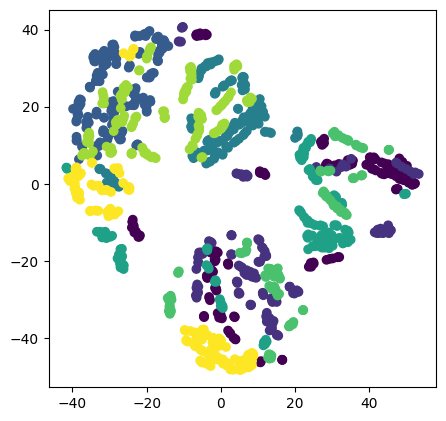

In [7]:
plt.figure(figsize=(5, 5))
plt.scatter(x_embedded[:,0], x_embedded[:,1], c=y)
plt.show()

Se observa del gráfico t-SNE que las clases de los datos están medianamente separados, por tanto, se espera que los modelos a entrenar tengan una precisión razonablemente alta.

**<h2>Separación de conjunto de entrenamiento de conjunto de pruebas</h2>**

In [8]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, train_size=0.8,random_state=0,stratify=y)
print(f"El tamaño del conjunto de prueba es: {x_train.shape}.")
print(f"El tamaño del conjunto de prueba es: {x_test.shape}.")

El tamaño del conjunto de prueba es: (864, 77).
El tamaño del conjunto de prueba es: (216, 77).


## Escalamiento de data

Se utilizará la clase ***pipeline*** para realizar el escalamiento sólo en la data de entrenamiento correspondiente a la validación ***k-fold***, dicho ***pipeline*** se definirá previo al entrenamiento de cada modelo.

# Algoritmos a entrenar

## Decision Tree

In [9]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
dt_imputer = SimpleImputer(strategy='mean')
dt_scaler = preprocessing.StandardScaler()
dt_model = DecisionTreeClassifier(class_weight="balanced", random_state=0)

dt_pipeline = pipeline.Pipeline([("imputer", dt_imputer), ("scaler", dt_scaler), ("dt", dt_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_dt = {'dt__criterion': ['gini', 'entropy'],
           'dt__max_depth': range(1, 31, 3),
           'dt__min_samples_split': range(2, 80, 1)}

In [10]:
#Busqueda aleatoria
r_search_dt = model_selection.RandomizedSearchCV(dt_pipeline,
                                                 grid_dt,
                                                 n_iter=80,
                                                 n_jobs=-1,
                                                 random_state=0)

r_search_dt.fit(x_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('dt',
                                              DecisionTreeClassifier(class_weight='balanced',
                                                                     random_state=0))]),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'dt__criterion': ['gini', 'entropy'],
                                        'dt__max_depth': range(1, 31, 3),
                                        'dt__min_samples_split': range(2, 80)},
                   random_state=0)

In [11]:
best_dt_pipeline = r_search_dt.best_estimator_

train_score = best_dt_pipeline.score(x_train, y_train)
test_score = best_dt_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo DT es: {train_score}.")
print(f"La exactitud de prueba para el modelo DT es: {test_score}.")

La exactitud de entrenamiento para el modelo DT es: 0.9953703703703703.
La exactitud de prueba para el modelo DT es: 0.875.


In [12]:
results_dt = pd.DataFrame(r_search_dt.cv_results_['params'])
results_dt['test_score'] = r_search_dt.cv_results_['mean_test_score']
results_dt.head()

,dt__min_samples_split,dt__max_depth,dt__criterion,test_score
0,9,13,gini,0.811299
1,29,10,entropy,0.777786
2,20,1,entropy,0.234985
3,35,22,gini,0.749946
4,26,16,gini,0.759208


In [13]:
alt.Chart(results_dt, 
          title='Comparacion de performance DT'
         ).mark_line(point=True).encode(
    alt.X('dt__max_depth', title='Profundidad maxima'),
    alt.Y('test_score', title='Score Medio CV', aggregate='average', scale=alt.Scale(zero=False)),
    color='dt__criterion'
)

alt.Chart(...)

## Random Forest

In [14]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
rfc_imputer = SimpleImputer(strategy='mean')
rfc_scaler = preprocessing.StandardScaler()
rfc_model = RandomForestClassifier(class_weight="balanced", criterion="gini", random_state=0)

rfc_pipeline = pipeline.Pipeline([("imputer", rfc_imputer),("scaler", rfc_scaler), ("rfc", rfc_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_rfc = {"rfc__n_estimators": range(1,1200,20), 
            "rfc__max_depth": range(1,31,3),
            "rfc__min_samples_split": range(2, 80, 2),
            "rfc__min_samples_leaf": range(1, 20, 1)}

In [15]:
#Busqueda aleatoria
r_search_rfc = model_selection.RandomizedSearchCV(rfc_pipeline, 
                                                  grid_rfc, 
                                                  n_iter=60, 
                                                  n_jobs=-1,
                                                  cv=8, 
                                                  random_state=0)
r_search_rfc.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('rfc',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=0))]),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'rfc__max_depth': range(1, 31, 3),
                                        'rfc__min_samples_leaf': range(1, 20),
                                        'rfc__min_samples_split': range(2, 80, 2),
                                        'rfc__n_estimators': range(1, 1200, 20)},
                   random_state=0)

In [16]:
best_rfc_pipeline = r_search_rfc.best_estimator_

train_score = best_rfc_pipeline.score(x_train, y_train)
test_score = best_rfc_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo RF es: {train_score}.")
print(f"La exactitud de prueba para el modelo RF es: {test_score}.")

La exactitud de entrenamiento para el modelo RF es: 1.0.
La exactitud de prueba para el modelo RF es: 0.9814814814814815.


#### Eliminación hacia atrás

In [17]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
rfc_imputer = SimpleImputer(strategy='mean')
rfc_scaler = preprocessing.StandardScaler()
rfc_model = RandomForestClassifier(class_weight="balanced",random_state=0)

imsc_imputer = rfc_imputer
imsc_scaler = rfc_scaler
imsc_pipeline = pipeline.Pipeline([("imputer", imsc_imputer), ("scaler", imsc_scaler)])

imsc_pipeline.fit(x_train)

x_train_imsc = imsc_pipeline.transform(x_train)

best_rfc_params = best_rfc_pipeline["rfc"].get_params()
best_rfc_model = RandomForestClassifier().set_params(**best_rfc_params)

rfecv = RFECV(estimator=best_rfc_model, step=1, cv=StratifiedKFold(8), scoring='accuracy')
rfecv.fit(x_train_imsc, y_train)

x_train_opt = rfecv.transform(x_train_imsc)

print("Número óptimo de características: %d" % x_train_opt.shape[1])

Número óptimo de características: 77


## KNN

In [18]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
knn_imputer = SimpleImputer(strategy='mean')
knn_scaler = preprocessing.StandardScaler()
knn_model = KNeighborsClassifier(n_jobs=-1)
knn_pipeline = pipeline.Pipeline([("imputer", knn_imputer),("scaler", knn_scaler), ("knn", knn_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_knn = {"knn__n_neighbors": range(1,10,1),
            "knn__leaf_size": range(1,6,1),
            "knn__weights": ['uniform', 'distance'],
            "knn__algorithm": ['auto', 'ball_tree','kd_tree','brute']}

In [19]:
#Busqueda aleatoria
r_search_knn = model_selection.RandomizedSearchCV(knn_pipeline, 
                                                  grid_knn, 
                                                  n_iter=360, 
                                                  n_jobs=-1,
                                                  cv=8, 
                                                  random_state=0)
r_search_knn.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('knn',
                                              KNeighborsClassifier(n_jobs=-1))]),
                   n_iter=360, n_jobs=-1,
                   param_distributions={'knn__algorithm': ['auto', 'ball_tree',
                                                           'kd_tree', 'brute'],
                                        'knn__leaf_size': range(1, 6),
                                        'knn__n_neighbors': range(1, 10),
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   random_state=0)

In [20]:
best_knn_pipeline = r_search_knn.best_estimator_

train_score = best_knn_pipeline.score(x_train, y_train)
test_score = best_knn_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo KNN es: {train_score}.")
print(f"La exactitud de prueba para el modelo KNN es: {test_score}.")

La exactitud de entrenamiento para el modelo KNN es: 1.0.
La exactitud de prueba para el modelo KNN es: 0.9953703703703703.


## Support Vector Machine

Primero se intentará con una svm lineal, para lo cual se le aplicará una búsqueda de grilla a un pipeline de imputador, escalador y clasificador.

### Linear SVM

In [21]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
svm_imputer = SimpleImputer(strategy='mean')
svm_scaler = preprocessing.StandardScaler()
svm_model = LinearSVC(class_weight="balanced",random_state=0, max_iter=3000)#SVC(kernel="rbf",class_weight="balanced",random_state=0)
svm_pipeline = pipeline.Pipeline([("imputer",svm_imputer), ("scaler", svm_scaler), ("model", svm_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
C = np.logspace(-4, 2, num=20)
grid_svm = {"model__C":C}

#Busqueda aleatoria
grid_search = model_selection.GridSearchCV(svm_pipeline, grid_svm, n_jobs=-1,cv=8)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        LinearSVC(class_weight='balanced',
                                                  max_iter=3000,
                                                  random_state=0))]),
             n_jobs=-1,
             param_grid={'model__C': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.35981829e-02, 6.95192796e-02, 1.43844989e-01, 2.97635144e-01,
       6.15848211e-01, 1.27427499e+00, 2.63665090e+00, 5.45559478e+00,
       1.12883789e+01, 2.33572147e+01, 4.83293024e+01, 1.00000000e+02])})

In [22]:
best_svm_pipeline = grid_search.best_estimator_

train_score = best_svm_pipeline.score(x_train, y_train)
test_score = best_svm_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo SVM con kernel RBF es: {train_score}.")
print(f"La exactitud de prueba para el modelo SVM con kernel RBF es: {test_score}.")

La exactitud de entrenamiento para el modelo SVM con kernel RBF es: 1.0.
La exactitud de prueba para el modelo SVM con kernel RBF es: 0.9814814814814815.


#### Eliminación hacia atrás

Debido a que la precisión de test puede mejorar, se realizará una selección de características por eliminación hacia atrás.

In [23]:
#Cabe resaltar que el selector RFECV no soporta el ingreso de datos de entrenamiento con valores faltantes, aún
#si el estimador es un pipeline con un imputador, para solucionar este problema, acá ya no se usa el pipeline
#por lo que se preprocesa la data antes de pasarlo al método fit del RFECV

transformation_pipeline = pipeline.Pipeline([("imputer",svm_imputer), ("scaler", svm_scaler)])
x_train_transformed = transformation_pipeline.fit_transform(x_train)
x_test_transformed = transformation_pipeline.transform(x_test)

#Utilizaré el modelo encontrado anteriormente
params = best_svm_pipeline["model"].get_params()
svm_model = LinearSVC()
svm_model.set_params(**params)

LinearSVC(C=0.615848211066026, class_weight='balanced', max_iter=3000,
          random_state=0)

In [24]:
rfecv = RFECV(estimator=svm_model, step=1, cv=8, scoring='accuracy')
rfecv.fit(x_train_transformed, y_train)

RFECV(cv=8,
      estimator=LinearSVC(C=0.615848211066026, class_weight='balanced',
                          max_iter=3000, random_state=0),
      scoring='accuracy')

In [25]:
train_score = rfecv.score(x_train_transformed, y_train)

test_score = rfecv.score(x_test_transformed, y_test)

print("Después de realizar la selección de características:")
print(f"la exactitud de entrenamiento para el modelo SVM con kernel RBF es: {train_score}.")
print(f"La exactitud de prueba para el modelo SVM con kernel RBF es: {test_score}.")

Después de realizar la selección de características:
la exactitud de entrenamiento para el modelo SVM con kernel RBF es: 1.0.
La exactitud de prueba para el modelo SVM con kernel RBF es: 0.9768518518518519.


In [56]:
print(f"Número óptimo de características : {rfecv.get_support().sum()}")

Número óptimo de características : 69


Podemos observar que la precisión de test disminuyó, esto se debe al hecho que el RFECV tiene una menor capacidad, en comparación a la búsqueda de grilla anterior, para encontrar el modelo que generaliza mejor, esto se debe al hecho de que se realiza la imputación a toda la data de entrenamiento y no sólo a la data de entrenamiento durante cada iteración de validación cruzada.

Como no se obtuvieron los resultados esperados al realizar la selección de características, entonces se implementará un clasificador SVM con una función de base radial como kernel.

### SVM con Kernel RBF

Para implementar esto se realizará un busqueda aleatoria haciendo uso de un pipeline de imputador, escalador y clasificador, pero ahora utilizando la selección de características obtenida con el SVM Lineal.


In [26]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
svm_imputer = SimpleImputer(strategy='mean')
svm_scaler = preprocessing.StandardScaler()
svm_model = SVC(kernel="rbf",class_weight="balanced",random_state=0)
svm_pipeline = pipeline.Pipeline([("imputer",svm_imputer), ("scaler", svm_scaler), ("model", svm_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
gamma = np.logspace(-4, 2, num=20)
C = np.logspace(-4, 2, num=20)
grid_svm = {"model__gamma":gamma, "model__C":C}

#Definición de la data reducida por la selección de características obtenida del linear SVM
x_train_reduced = x_train.iloc[:,rfecv.get_support()]
x_test_reduced = x_test.iloc[:,rfecv.get_support()]
#Busqueda aleatoria
r_search = model_selection.RandomizedSearchCV(svm_pipeline, grid_svm, n_iter=40,n_jobs=-1,cv=8, random_state=0)

In [27]:
r_search.fit(x_train_reduced, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              SVC(class_weight='balanced',
                                                  random_state=0))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'model__C': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.3598182...
       1.12883789e+01, 2.33572147e+01, 4.83293024e+01, 1.00000000e+02]),
                                        'model__gamma': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.35981829e-02, 6.95192796e-02, 1.43844989e-01, 2.97635144e-01,
       6.15848211e-01, 1.274

In [28]:
best_svm_pipeline = r_search.best_estimator_

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline

train_score = best_svm_pipeline.score(x_train_reduced, y_train)
test_score = best_svm_pipeline.score(x_test_reduced, y_test)

print(f"La exactitud de entrenamiento para el modelo SVM con kernel RBF es: {train_score}.")
print(f"La exactitud de prueba para el modelo SVM con kernel RBF es: {test_score}.")

La exactitud de entrenamiento para el modelo SVM con kernel RBF es: 1.0.
La exactitud de prueba para el modelo SVM con kernel RBF es: 1.0.


## Redes neuronales

Para implementar las redes neuronales, se aplicó un procedimiento de validación cruzada con imputación y escalamiento similar a los utilizados en los entrenamientos de los demás algoritmos, con excepción de que aquí la validación cruzada también puede ser usada para validar la inicialización de los pesos de la red neuronal para lograr así una mejor exactitud de validación; este método debe ser analizado con cuidado, ya que una exhaustiva selección del modelo que mejor prediga la data de validación puede provocar que se seleccione un modelo sobreajustado a la data de validación. Esto sucedió en un inicio y se pudo corroborar con la caída de la precisión de test, por lo tanto se decidió realizar solo una inicialización por arquitectura. 

En un inicio se hizo una búsqueda aleatoria con una cantidad de capas variable, pero se observó que la data puede ser fácilmente caracterizada con una red neuronal de solo dos capas ocultas, por tal motivo el número de capas se fijó a 2.

In [29]:
#Definición de arquitecturas
numberOfUnitsInHiddenLayer = range(8, 50)
numberOfLayers = [3] # Puede ser sustituido por una lista range(2, 7), en este caso no fue necesario
activationFunctionsHidden = ["tanh"]
# Se puede utilizar relu como función de activación para tener un entrenamiento más rápido, "relu", 
# en este caso no fue necesario.

In [30]:
ntries = 20 #Número de búsquedas aleatorias de arquitectura
NUM_EPOCHS = 10000
tries = set() #Set que guardará las arquitecturas ya probadas
random.seed(0)

for i in range(ntries):
    print(f"Iteración de búsqueda aleatoria {i+1}")
    print("---------------------------------------")
    while(True):
        nlayers = random.choice(numberOfLayers)
        
        #Genera una lista de números de neuronas para cada capa, teniendo en cuenta que este número debe ir 
        #decreciendo conforme se llegue a la capa de salida.
        numberOfUnitsPerLayer = [8]#Para generar la salida de 8 clases
        for j in range(nlayers-1):
            index = numberOfUnitsInHiddenLayer.index(numberOfUnitsPerLayer[0])
            new_index = numberOfUnitsInHiddenLayer.index(min(2*numberOfUnitsPerLayer[0], 49))
            newNumberOfUnits = random.choice(numberOfUnitsInHiddenLayer[index:new_index])
            numberOfUnitsPerLayer.insert(0, newNumberOfUnits)
            
        #Seleccionamos aleatoriamente las funciones de activación de cada capa, con excepción de la capa de salida
        #que siempre emplea una función de activación softmax, en esta implementación, por recomendación de Tensorflow
        #la función softmax es aplicada por la función de pérdida, por lo que la capa de salida será lineal(None)
        numberOfActivationFunctionsPerLayer = [random.choice(activationFunctionsHidden) for j in range(nlayers)]
        numberOfActivationFunctionsPerLayer[-1] = None

        arch_str = str(numberOfUnitsPerLayer)+str(numberOfActivationFunctionsPerLayer)
        if not (arch_str in tries):
            tries.add(arch_str)
            break
    
    print(f"Arquitectura: {numberOfUnitsPerLayer}. Activation Functions: {numberOfActivationFunctionsPerLayer}\n")
    arch = ANNArchitecture(numberOfUnitsPerLayer, numberOfActivationFunctionsPerLayer)
    redNeuronal = FeedForwardNeuralNetwork(architecture=arch)
    
    redNeuronal.fitCV(x_train, y_train, learningRate=0.001, numberOfEpochs=NUM_EPOCHS, minibatchSize=64, 
                      verbose=False, numberOfInitializations=1, cv=8, randomState=0)
    

    
print("Fin de búsqueda aleatoria de características con validación cruzada k-fold k=8")



Iteración de búsqueda aleatoria 1
---------------------------------------
Arquitectura: [14, 14, 8]. Activation Functions: ['tanh', 'tanh', None]

La mejor inicialización para esta arquitectura logró una exactitud de validación promedio: 0.9930555447936058 y una exactitud de entrenamiento promedio: 1.0.


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:01:05. Número de épocas:140.

Costo de entrenamiento:0.010199774987995625. Exactitud de entrenamiento:1.0.


Iteración de búsqueda aleatoria 2
---------------------------------------
Arquitectura: [20, 15, 8]. Activation Functions: ['tanh', 'tanh', None]

La mejor inicialización para esta arquitectura logró una exactitud de validación promedio: 0.9953703656792641 y una exactitud de entrenamiento promedio: 1.0.


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:00:56. Nú

La mejor inicialización para esta arquitectura logró una exactitud de validación promedio: 0.9837962985038757 y una exactitud de entrenamiento promedio: 1.0.


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:00:51. Número de épocas:122.

Costo de entrenamiento:0.009901786223053932. Exactitud de entrenamiento:1.0.


Iteración de búsqueda aleatoria 17
---------------------------------------
Arquitectura: [11, 9, 8]. Activation Functions: ['tanh', 'tanh', None]

La mejor inicialización para esta arquitectura logró una exactitud de validación promedio: 0.9872685074806213 y una exactitud de entrenamiento promedio: 1.0.


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:01:18. Número de épocas:163.

Costo de entrenamiento:0.013096415437757969. Exactitud de entrenamiento:1.0.


Iteración de búsqueda aleatoria 18
------------

La mejor arquitectura encontrada fue una red neuronal con dos capas ocultas con funciones de activación tangente hiperbólica, que tiene 20 neuronas en la primera capa oculta y con 15 neuronas en la segunda capa oculta, y finalmente 8 neuronas y una función de activación softmax en la capa de salida.

In [31]:
print(f"Arquitectura: 20-15-8. Activation Functions: tanh-tanh-softmax\n")

arch = ANNArchitecture([20, 15,8], ["tanh","tanh",None])
redNeuronal = FeedForwardNeuralNetwork(architecture=arch)
redNeuronal.fitCV(x_train, y_train, learningRate=0.001, numberOfEpochs=10000, minibatchSize=64, 
                  verbose=False, numberOfInitializations=1, cv=None, randomState=0)

Arquitectura: 20-15-8. Activation Functions: tanh-tanh-softmax


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:00:03. Número de épocas:15.

Costo de entrenamiento:0.001848480198532343. Exactitud de entrenamiento:1.0.




In [33]:
test_cost = redNeuronal.score(x_test, y_test)
print ("Test SCCE:", test_cost)

Test SCCE: 0.9953703880310059


Dado que la precisión de test lograda es bastante alta, no se realizará una selección de características para las redes neuronales porque sería excesivamente costoso.

## Naive Bayes

Se implementará Naive Bayes Gaussiano, se realizará una búsqueda aleatoria para las probabilidades a priori, aunque se puede deducir que el dejar que el algoritmo las cálcule probablemente sea lo óptimo.

In [34]:
random.seed(0)
#Definición de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
naive_imputer = SimpleImputer(strategy='mean')
naive_scaler = preprocessing.StandardScaler()
naive_model = naive_bayes.GaussianNB()
naive_pipeline = pipeline.Pipeline([("imputer",naive_imputer), ("scaler", naive_scaler), ("model", naive_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
priors = [None]

while(len(priors)<1000):
    priorsItem = []
    probabilityLeft = 1
    
    save = True
    for j in range(8):
        prob = random.uniform(0, probabilityLeft)
        if prob <=0.01:
            save = False
            break
        priorsItem.append(prob)
        probabilityLeft -= prob
    
    if (0 not in priorsItem) and save:
        priors.append(priorsItem)

grid_naive = {"model__priors":priors}

In [35]:
#Busqueda de grilla
grid_search =model_selection.GridSearchCV(naive_pipeline, grid_naive, n_jobs=-1,cv=8)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model', GaussianNB())]),
             n_jobs=-1,
             param_grid={'model__priors': [None,
                                           [0.42561883196681716,
                                            0.05829981455975992,
                                            0.13413980851894763,
                                            0.08434387305772524,
                                            0.19252358811312115,
                                            0.03680681767912299,
                                            0.012309810167133287,
                                            0.028182217548734585],
                                           [0.40862622118314...
                                            0.03169835559401494,
                                            0.027751

In [36]:
grid_search.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', GaussianNB())])

In [37]:
best_naive_pipeline = grid_search.best_estimator_

train_score = best_naive_pipeline.score(x_train, y_train)
test_score = best_naive_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo naive Bayes Gaussiano es: {train_score}.")
print(f"La exactitud de prueba para el modelo naive Bayes Gaussiano es: {test_score}.")

La exactitud de entrenamiento para el modelo naive Bayes Gaussiano es: 0.8032407407407407.
La exactitud de prueba para el modelo naive Bayes Gaussiano es: 0.8148148148148148.


No se realizó eliminación hacia atrás debido a que el modelo Gaussian Naive Bayes no tiene los atributos coef_ o feature_importances_, atributos que son utilizados por el selector de características RFECV de Sklearn. Se probó con la selección de características de SVM, pero se obtuvo error de test mucho mayor.

## Regresión Logística

In [48]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
lr_imputer = SimpleImputer(strategy='mean')
lr_scaler = preprocessing.StandardScaler()
lr_model = LogisticRegression(penalty="l2", class_weight="balanced", solver="lbfgs", random_state=47, max_iter=600)
lr_pipeline = pipeline.Pipeline([("imputer", lr_imputer), ("scaler", lr_scaler), ("model", lr_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
C = np.logspace(-4, 4, num=401)

grid_lr = {"model__C":C}

In [49]:
#Busqueda aleatoria
r_search = model_selection.RandomizedSearchCV(lr_pipeline, grid_lr, n_iter=40, n_jobs=-1, cv=8, random_state=47)
r_search.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=600,
                                                                 random_state=47))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'model__C': array([1.00000000e-04, 1.04712855e-04, 1.09647820e-04, 1.14815362e-04,
       1.20226443e-04, 1.25892541e-04, 1.31825674...
       3.31131121e+03, 3.46736850e+03, 3.63078055e+03, 3.80189396e+03,
       3.98107171e+03, 4.16869383e+03, 4.36515832e+03, 4.57088190e+03,
       4.78630092e+03, 5.01187234e+03, 5.24807460e+03, 5.49540874e+03,
       5.75439937e+03, 6.02559586e+03, 6.30957344e+03, 6.60693448e+03,
       6.91830

In [50]:
best_lr_pipeline = r_search.best_estimator_

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_lr_pipeline.score(x_train, y_train)
test_score = best_lr_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo Regresión Logística: {train_score}.")
print(f"La exactitud de prueba para el Regresión Logística es: {test_score}.")

La exactitud de entrenamiento para el modelo Regresión Logística: 1.0.
La exactitud de prueba para el Regresión Logística es: 0.9861111111111112.


### Eliminación hacia atrás

In [51]:
#Definicion de imputación y escalamiento para datos y agrupación en pipeline
imsc_imputer = lr_imputer
imsc_scaler = lr_scaler
imsc_pipeline = pipeline.Pipeline([("imputer", imsc_imputer), ("scaler", imsc_scaler)])
imsc_pipeline.fit(x_train)

#Aplicación del pipeline para obtener data aplicable para el modelo de eliminación hacia atrás
x_train_imsc = imsc_pipeline.transform(x_train)

#Mejor modelo obtenido para Regresión Logística
best_model = best_lr_pipeline["model"]

#Eliminación hacia atrás para el mejor modelo
rfecv = RFECV(estimator=best_model, step=1, cv=StratifiedKFold(8), scoring='accuracy')
rfecv.fit(x_train_imsc, y_train)

#Transformación de datos de entrenamiento
x_train_opt = rfecv.transform(x_train_imsc)

print("Número óptimo de características : %d" % x_train_opt.shape[1])

Número óptimo de características : 69


In [52]:
#Entrenando con las características óptimas en entrenamiento (como parámetro warm_start es FALSE, se entrena de nuevo)
best_model.fit(x_train_opt, y_train)

#Transformación de datos de prueba
x_test_imsc = imsc_pipeline.transform(x_test)
x_test_opt = rfecv.transform(x_test_imsc)

#Exactitud del modelo en conjuntos de entrenamiento y prueba
train_score = best_model.score(x_train_opt, y_train)
test_score = best_model.score(x_test_opt, y_test)

print(f"La exactitud de entrenamiento para el modelo Regresión Logística: {train_score}.")
print(f"La exactitud de prueba para el modelo Regresión Logística es: {test_score}.")

La exactitud de entrenamiento para el modelo Regresión Logística: 1.0.
La exactitud de prueba para el modelo Regresión Logística es: 0.9814814814814815.


## LightGBM

In [57]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
lgbm_imputer = SimpleImputer(strategy='mean')
lgbm_scaler = preprocessing.StandardScaler()
lgbm_model = LGBMClassifier()
lgbm_pipeline = pipeline.Pipeline([("imputer", lgbm_imputer), ("scaler", lgbm_scaler), ("lgbm", lgbm_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_lgbm = {"lgbm__max_bin": np.power(2, range(7,10,3)), 
             "lgbm__learning_rate": [2.5e-3,5-3,7.5e-3,1e-2],
             "lgbm__num_leaves": range(250, 500, 25),
             "lgbm__num_iterations": [500]}

In [58]:
lgbm_search = model_selection.RandomizedSearchCV(lgbm_pipeline, grid_lgbm, n_iter=20, n_jobs=-1, cv=8, random_state=47)
lgbm_search.fit(x_train, y_train)

/Users/alejandro/anaconda3/envs/ProyectoINF648/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('lgbm', LGBMClassifier())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'lgbm__learning_rate': [0.0025, 2,
                                                                0.0075, 0.01],
                                        'lgbm__max_bin': array([128]),
                                        'lgbm__num_iterations': [500],
                                        'lgbm__num_leaves': range(250, 500, 25)},
                   random_state=47)

In [59]:
best_lgbm_pipeline = lgbm_search.best_estimator_

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_lgbm_pipeline.score(x_train, y_train)
test_score = best_lgbm_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo LightGBM: {train_score}.")
print(f"La exactitud de prueba para el modelo LightGBM: {test_score}.")

La exactitud de entrenamiento para el modelo LightGBM: 1.0.
La exactitud de prueba para el modelo LightGBM: 0.9537037037037037.


### Eliminación hacia atrás

In [60]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
imsc_imputer = lgbm_imputer
imsc_scaler = lgbm_scaler
imsc_pipeline = pipeline.Pipeline([("imputer", imsc_imputer), ("scaler", imsc_scaler)])

imsc_pipeline.fit(x_train)

x_train_imsc = imsc_pipeline.transform(x_train)

best_lgbm_params = best_model.get_params()
best_model = LGBMClassifier().set_params(**best_lgbm_params)

rfecv = RFECV(estimator=best_model, step=1, cv=StratifiedKFold(8), scoring='accuracy')
rfecv.fit(x_train_imsc, y_train)

x_train_opt = rfecv.transform(x_train_imsc)

print("Número óptimo de características : %d" % x_train_opt.shape[1])

Número óptimo de características : 34


In [61]:
best_model.fit(x_train_opt, y_train)

x_test_imsc = imsc_pipeline.transform(x_test)
x_test_opt = rfecv.transform(x_test_imsc)

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_model.score(x_train_opt, y_train)
test_score = best_model.score(x_test_opt, y_test)

print(f"La exactitud de entrenamiento para el modelo LightGBM es: {train_score}.")
print(f"La exactitud de prueba para el modelo LightGBM es: {test_score}.")

La exactitud de entrenamiento para el modelo LightGBM es: 1.0.
La exactitud de prueba para el modelo LightGBM es: 0.9722222222222222.


# Estado del arte

In [62]:
preprocDataset_stt = dataset.copy()

preprocDataset_stt.drop("MouseID", axis=1, inplace=True)

from sklearn.preprocessing import LabelEncoder

preprocDataset_stt["class"] = LabelEncoder().fit_transform(preprocDataset_stt["class"])
preprocDataset_stt["Genotype"] = LabelEncoder().fit_transform(preprocDataset_stt["Genotype"])
preprocDataset_stt["Treatment"] = LabelEncoder().fit_transform(preprocDataset_stt["Treatment"])
preprocDataset_stt["Behavior"] = LabelEncoder().fit_transform(preprocDataset_stt["Behavior"])

x = preprocDataset_stt.drop("class",axis=1)
y = preprocDataset_stt["class"]

In [63]:
x_stt_train, x_stt_test, y_stt_train, y_stt_test = model_selection.train_test_split(x, y, train_size=0.7,random_state=0,stratify=y)
print(f"El tamaño del conjunto de prueba es: {x_stt_train.shape}.")
print(f"El tamaño del conjunto de prueba es: {x_stt_test.shape}.")

El tamaño del conjunto de prueba es: (756, 80).
El tamaño del conjunto de prueba es: (324, 80).


In [64]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
stt_imputer = SimpleImputer(strategy='median')
stt_scaler = preprocessing.StandardScaler()
stt_pipeline = pipeline.Pipeline([("imputer", stt_imputer), ("scaler", stt_scaler)])

stt_pipeline.fit(x_stt_train)

x_train_model = stt_pipeline.transform(x_stt_train)

stt_model = RandomForestClassifier(n_estimators=50, max_features=8, criterion='entropy', class_weight="balanced", random_state=0, oob_score=True)
stt_model.fit(x_train_model, y_stt_train)

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
x_test_model = stt_pipeline.transform(x_stt_test)

oob_error = 1 - stt_model.oob_score_
train_stt_score = stt_model.score(x_train_model, y_stt_train)
test_stt_score = stt_model.score(x_test_model, y_stt_test)

print(f"La exactitud de entrenamiento para el modelo del estado del arte es: {train_stt_score}.")
print(f"La exactitud de prueba para el modelo del estado del arte es: {test_stt_score}.")
print(f"Error OOB obtenido por el modelo del estado del arte es: {oob_error}.")

La exactitud de entrenamiento para el modelo del estado del arte es: 1.0.
La exactitud de prueba para el modelo del estado del arte es: 1.0.
Error OOB obtenido por el modelo del estado del arte es: 0.001322751322751281.
